# Validation

In [75]:
# general
import copy
import os
from collections import Counter, defaultdict
import cv2
import numpy as np

# custom code
import torch
from detectron2.engine import DefaultPredictor
from zebrafish.configs import load_config
from zebrafish.dataset import get_dataset, register_datasets, load_all_image_in_dataset
from zebrafish.evaluation import coco_evaluation, coco_evaluation_all_model
from zebrafish.model import predict
from zebrafish.visualization import plot_prediction, plot_train_vs_validation_loss, plot_segementation, plot_segementation_vs_real, plot_all_model_validation_loss
from zebrafish.utils import is_in_main_dir

#detectron
from detectron2.utils.logger import setup_logger
from detectron2.structures.boxes import matched_boxlist_iou
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from zebrafish.evaluation import evaluate_confusion_on_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

setup_logger()

if "notebooks" in os.getcwd() and "colab" in os.getcwd():
    os.chdir("..")
    os.chdir("..")

assert is_in_main_dir(), "The notebook expectes you to be in the main directory"

register_datasets("dataset")

## Restore model

In [76]:
model_name = "mask_rcnn_R_50_FPN_3x_ND_BS1_FA0_WUI0_RIOBS_512_DA_RF1_TAUG_train_without_direction"
#model_name = "2020_06_05_17_28_10"
#model_name = "mask_rcnn_R_50_FPN_3x_WD_BS1_FA0_WUI0_RIOBS_512_DA_RF1_FL_RO_TAUG_train_direction"
n_images = 1
path_to_model = "output/" + model_name


cfg = load_config(path_to_model)

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

predictor = DefaultPredictor(cfg)

In [77]:
from detectron2.data import detection_utils as utils

def mapper(dataset_dict):
	# Implement a mapper, similar to the default DatasetMapper, but with your own customizations
	dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
	image = utils.read_image(dataset_dict["file_name"], format="BGR")

	dataset_dict["image"] = image

	instances = utils.annotations_to_instances(dataset_dict["annotations"], image.shape[:2])
	dataset_dict["instances"] = utils.filter_empty_instances(instances)

	return dataset_dict

In [78]:
dataset_name = "test"

dataset = get_dataset(dataset_name, cfg)
item = mapper(dataset[0])
prediction = predictor(item["image"])

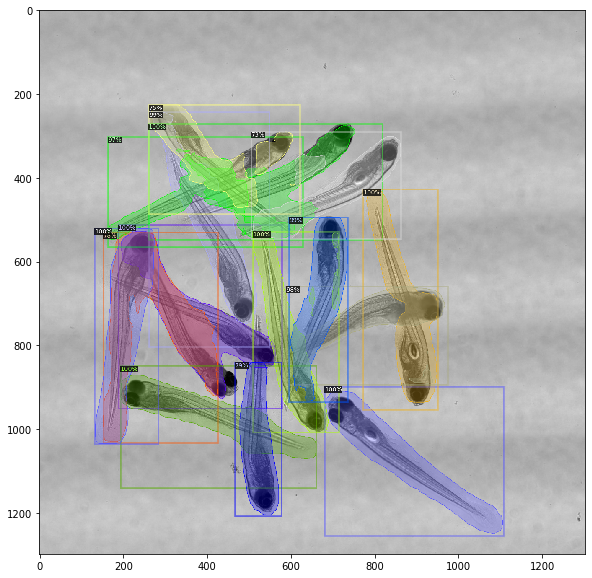

In [79]:
plot_prediction(item["image"], prediction, cfg)

In [80]:

y_pred, y_true = evaluate_confusion_on_dataset(cfg, dataset_name)

In [81]:
len(y_pred), len(y_true)

(66, 66)

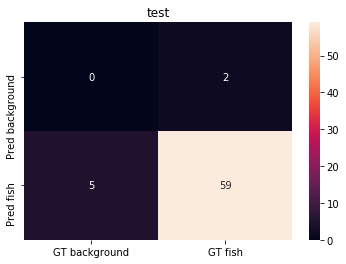

f1 = 0.9153939393939393
accuracy = 0.8939393939393939
model =  mask_rcnn_R_50_FPN_3x_ND_BS1_FA0_WUI0_RIOBS_512_DA_RF1_TAUG_train_without_direction


In [82]:
m = confusion_matrix(y_true, y_pred)
df = pd.DataFrame(m, index=["Pred background", "Pred fish"], columns=["GT background", "GT fish"])
#df = pd.DataFrame(m, index=["Pred background", "Pred Deformed", "Pred Healthy"], columns=["GT background", "GT Deformed", "GT Healthy"])
sn.heatmap(df, annot=True)
plt.title(dataset_name)
plt.show()
print(f'f1 = {f1_score(y_true, y_pred, average="weighted")}')
print(f'accuracy = {accuracy_score(y_true, y_pred)}')
print("model = ", model_name)


In [83]:
f1_score(y_true, y_pred, average="weighted")

0.9153939393939393